# Introduction to Conditional GAN(cGAN) 

- [Paper: Conditional generative adversarial nets](https://arxiv.org/pdf/1411.1784.pdf)
- https://learnopencv.com/conditional-gan-cgan-in-pytorch-and-tensorflow/

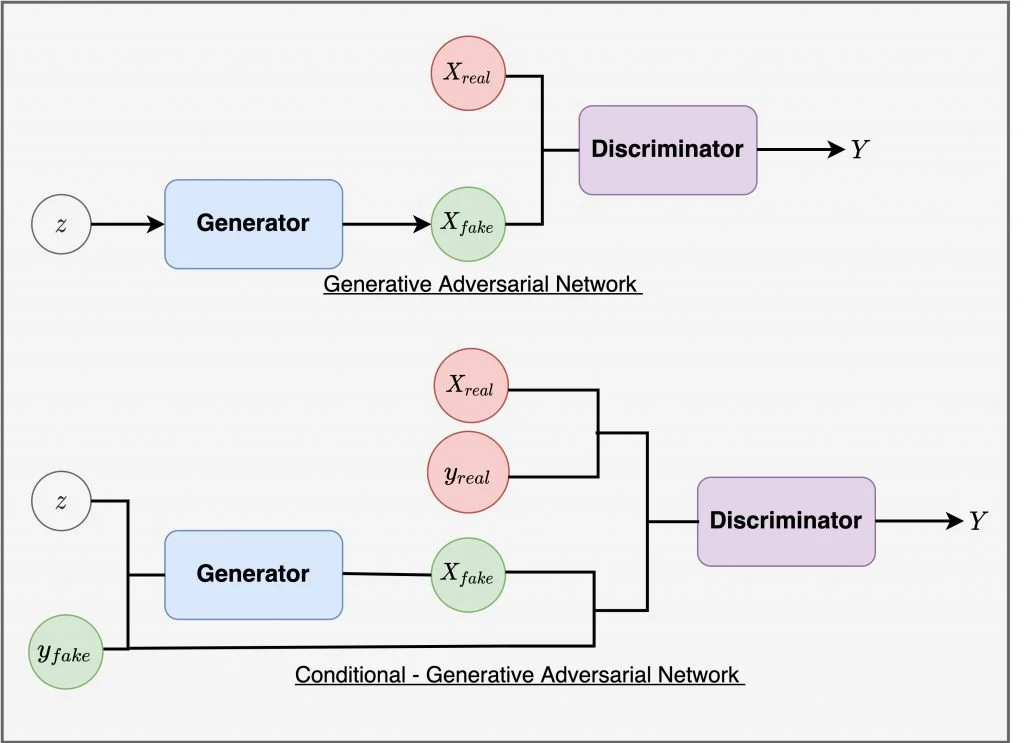<br><br>
GAN이 realistic samples을 생성하는 능력이 있지만, 우리는 어떤 이미지들을 만들라고 통제할 수는 없습니다.<br> 
만약 FashionMNIST로 학습한 GAN이 셔츠 이미지들만 생성하게 만들고 싶다면, 어떻게 해야 할까요?<br>
Conditional GAN을 통해서 GAN이 생성할 이미지들을 통제할 수 있습니다<br>

# 1. What is Conditional GAN?
2014년 Mehdi Mirza와 Simon Osindero는 Conditional Generative Adversarial Nets(https://arxiv.org/pdf/1411.1784.pdf) 라는 논문을 발표했습니다. Original GAN모델의 Generator와 Discriminator가 training중 condition(external information)을 받는 것입니다. External information은 label이 될 수도 있고, 다른 형태의 데이터가 될 수도 있습니다.<br>
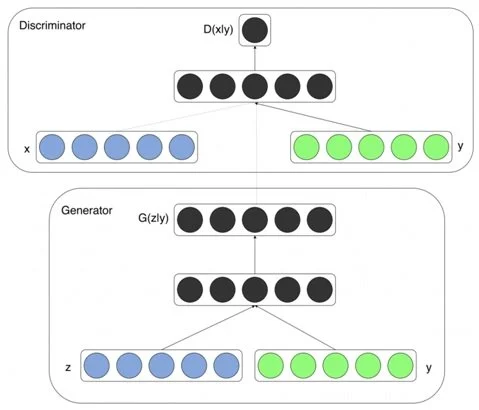<br>
위의 그림을 살펴보면 핵심 아이디어는 매우 단순합니다. G와 D가 동시에 condition인 class label **y**를 입력으로 추가적으로 받습니다. 다른 구조는 original GAN에서 살펴본 것과 동일합니다.

> CGAN의 훈련과정 중에서
1. G는 training dataset의 각각의 라벨에 대응하는 실제적인 샘플을 만드는 과정을 학습합니다<br>
2. D는 y가 주어진 상태에서 real, fake 샘플들을 구별하는 방법을 배웁니다.<br>
3. G와 D의 기본적인 역할은 동일합니다. G는 D를 속이려 하며, D는 real, fake를 잘 구별하려 합니다. 단지 auxiliary information이 추가될 뿐입니다.<br>

# 2. Purpose of Conditional Generator and Discriminator
## Generator
일반적으로, G는 랜덤 노이즈 벡터를 필요로 합니다. Conditional한 generation에서는 하지만, 추가적인 정보를 필요로 하며, 이것을 통해 generator에서 어떤 class의 sample을 만들어야 하는지 알려줍니다. **y**를 conditioning label이라 하면, Generator는 noise vector z와 label y를 이용하여 fake examples인 **G(z,y)**를 만들어냅니다. Fake example의 목표는 앞서 말했듯이, D를 속이는 것으로 최대한 주어진 label의 real과 비슷한 샘플들을 만드는 것입니다.<br>

Generator는 realisitc한 데이터를 만드는 것뿐만 아니라, 해당 label에 해당하는 샘플들을 만들어야 합니다. 만약 특정 class label 1이 G에게 주어지면, G는 1에 해당하는 이미지들을 생성해야 합니다. G가 fully-trained 되었다면, 단순히 desired한 label을 던져줌으로써 CGAN이 생성하는 샘플을 조정할 수 있습니다. 

## Discriminator
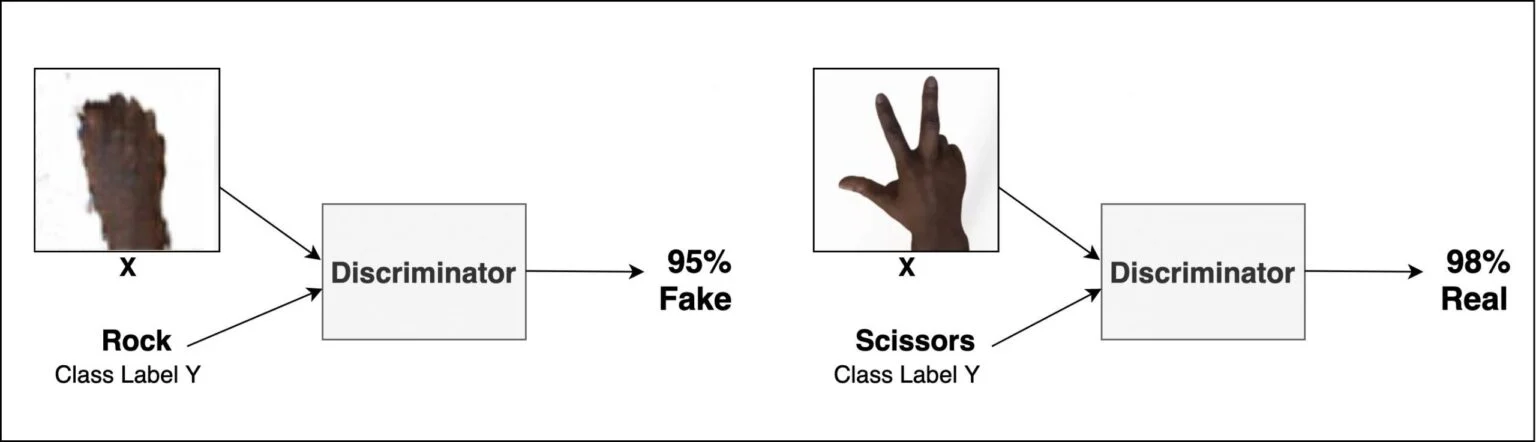
Discriminator는 real, fake examples을 labels과 같이 동시에 입력으로 받습니다. real data와 fake를 구분하여, 최종적으로 input이 real or fake인지 알려주는 확률을 반환합니다.
> Goal of Discriminator
- real sample과 labels의 쌍을 accept<br>
- fake sample과 labels의 쌍을 reject -> label에 해당되는 fake images를 reject<br>
- fake sample이 label과 matching이 안되면 reject -> label이 1인데 generated된 이미지가 2인 경우 reject<br>

# 3. Pytorch Implementation

## Dataset
- **MNIST**
- **FashionMNIST**<br>

In [53]:
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import utils
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Dataset

In [15]:
# Set Data path
datapath = './data'
os.makedirs(datapath, exist_ok=True)

# Pre-process
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Laod MNIST
train_dataset = datasets.MNIST(datapath, train=True, download=True, transform=trans)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



C:\Users\wilko\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Check Sample images

img.shape: torch.Size([60000, 28, 28])
label.shape: torch.Size([60000])
Unsqueezed img.shape: torch.Size([60000, 1, 28, 28])


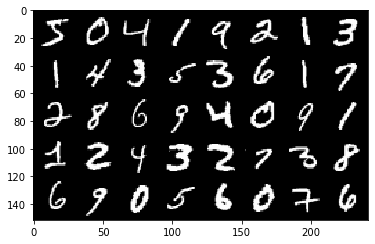

In [28]:
img, label = train_dataset.data, train_dataset.targets
print('img.shape:', img.shape)
print('label.shape:', label.shape)

# Make it to 4D Tensor
# 기존 : (#Batch) x (height) x (width) -> (#Batch) x (#channel) x (height) x(width)
if len(img.shape) == 3:
    img = img.unsqueeze(1)
print('Unsqueezed img.shape:', img.shape)

# Visualize
img_grid = utils.make_grid(img[:40], ncol=8, padding=2)
def show(img):
    img = img.numpy() # Tensor -> numpy array
    img = img.transpose([1,2,0]) # C x H x W -> H x W x C
    plt.imshow(img, interpolation='nearest')
show(img_grid)

## DataLoader
Dataset -> mini-batch dataset

In [35]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print(len(train_loader))

938


## Define model

In [37]:
# set parameters
params = {
    'num_classes':10,
    'nz':100,
    'input_size':(1,28,28)
}

## Generator

In [41]:
class Generator(nn.Module):
    
    def __init__(self, params):
        super().__init__()
        self.num_classes = params['num_classes']
        self.nz = params['nz'] # 노이즈 수
        self.input_size = params['input_size'] # (1,28,28
        
        # Noise와 label을 결합하는 용도인 label embedding matrix를 생성
        self.label_emb = nn.Embedding(self.num_classes, self.num_classes)
        
        # Generator
        self.gen = nn.Sequential(
            nn.Linear(self.nz + self.num_classes, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,int(np.prod(self.input_size))),
            nn.Tanh()
        )
        
    def forward(self, noise, labels):
        # noise와 label의 결합
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        x = self.gen(gen_input)
        x = x.view(x.size(0), *self.input_size)
        return x
    
# check
x = torch.randn(16,100,device=device) # 노이즈
label = torch.randint(0,10,(16,),device=device) # 레이블
model_gen = Generator(params).to(device)
out_gen = model_gen(x,label) # 가짜 이미지 생성
print(out_gen.shape)

torch.Size([16, 1, 28, 28])


## Discriminator

In [47]:
class Discriminator(nn.Module):
    
     def __init__(self, params):
        super().__init__()
        self.input_size = params['input_size']
        self.num_classes = params['num_classes']
        self.label_embedding = nn.Embedding(self.num_classes, self.num_classes)
        self.dis = nn.Sequential(
            nn.Linear(self.num_classes+int(np.prod(self.input_size)),512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2),
            nn.Linear(512,1),
            nn.Sigmoid()
        )
        
     def forward(self, img, labels):
        # 이미지와 label 결합
        dis_input = torch.cat((img.view(img.size(0),-1),self.label_embedding(labels)),-1)
        x = self.dis(dis_input)
        return x
    
# check
x = torch.randn(16,1,28,28,device=device)
label = torch.randint(0,10,(16,), device=device)
model_dis = Discriminator(params).to(device)
out_dis = model_dis(x,label)
print(out_dis.shape)

torch.Size([16, 1])


## 가중치 초기화

In [50]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    # fc layer
    if classname.find('Linear') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
        nn.init.constant_(model.bias.data, 0)
    # batchnorm
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# 가중치 초기화 적용
model_gen.apply(initialize_weights);
model_dis.apply(initialize_weights);

## 학습하기

In [51]:
# 손실 함수
loss_func = nn.BCELoss() 

from torch import optim

lr = 2e-4
beta1 = 0.5
beta2 = 0.999

# optimization
opt_dis = optim.Adam(model_dis.parameters(), lr=lr, betas=(beta1,beta2)) # Discrminator
opt_gen = optim.Adam(model_gen.parameters(), lr=lr, betas=(beta1,beta2)) # Generator

# 학습 파라미터
nz = params['nz'] # Noise vector initialize
num_epochs = 100

loss_history={'gen':[],
              'dis':[]}

In [54]:
# Train
batch_count = 0
start_time = time.time()
model_dis.train()
model_gen.train()

for epoch in range(num_epochs):
    for xb, yb in train_loader:
        ba_si = xb.shape[0]
        
        xb = xb.to(device)
        yb = yb.to(device)
        yb_real = torch.Tensor(ba_si, 1).fill_(1.0).to(device) # real_label
        yb_fake = torch.Tensor(ba_si, 1).fill_(0.0).to(device) # fake_label
        
        # Genetator
        model_gen.zero_grad()
        noise = torch.randn(ba_si,100).to(device) # 노이즈 생성
        gen_label = torch.randint(0,10,(ba_si,)).to(device) # label 생성

         # 가짜 이미지 생성
        out_gen = model_gen(noise, gen_label)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen, gen_label)

        loss_gen = loss_func(out_dis, yb_real)
        loss_gen.backward()
        opt_gen.step()

        # Discriminator
        model_dis.zero_grad()
        
        # 진짜 이미지 판별
        out_dis = model_dis(xb, yb)
        loss_real = loss_func(out_dis, yb_real)

        # 가짜 이미지 판별
        out_dis = model_dis(out_gen.detach(),gen_label)
        loss_fake = loss_func(out_dis,yb_fake)

        loss_dis = (loss_real + loss_fake) / 2
        loss_dis.backward()
        opt_dis.step()

        loss_history['gen'].append(loss_gen.item())
        loss_history['dis'].append(loss_dis.item())

        batch_count += 1
        if batch_count % 1000 == 0:
            print('Epoch: %.0f, G_Loss: %.6f, D_Loss: %.6f, time: %.2f min' %(epoch, loss_gen.item(), loss_dis.item(), (time.time()-start_time)/60))

Epoch: 1, G_Loss: 1.542109, D_Loss: 0.460845, time: 0.18 min
Epoch: 2, G_Loss: 1.331141, D_Loss: 0.449865, time: 0.36 min
Epoch: 3, G_Loss: 0.764480, D_Loss: 0.561866, time: 0.53 min
Epoch: 4, G_Loss: 2.191552, D_Loss: 0.683489, time: 0.70 min
Epoch: 5, G_Loss: 1.541512, D_Loss: 0.522303, time: 0.87 min
Epoch: 6, G_Loss: 1.048354, D_Loss: 0.545157, time: 1.04 min
Epoch: 7, G_Loss: 1.508149, D_Loss: 0.559495, time: 1.21 min
Epoch: 8, G_Loss: 1.085185, D_Loss: 0.492416, time: 1.38 min
Epoch: 9, G_Loss: 0.970094, D_Loss: 0.548921, time: 1.56 min
Epoch: 10, G_Loss: 1.723333, D_Loss: 0.688640, time: 1.73 min
Epoch: 11, G_Loss: 0.679538, D_Loss: 0.625146, time: 1.91 min
Epoch: 12, G_Loss: 0.806413, D_Loss: 0.506373, time: 2.08 min
Epoch: 13, G_Loss: 1.258373, D_Loss: 0.560056, time: 2.25 min
Epoch: 14, G_Loss: 1.164105, D_Loss: 0.576755, time: 2.42 min
Epoch: 15, G_Loss: 1.110833, D_Loss: 0.533988, time: 2.59 min
Epoch: 17, G_Loss: 0.806488, D_Loss: 0.561823, time: 2.76 min
Epoch: 18, G_Loss

## Visualize Loss

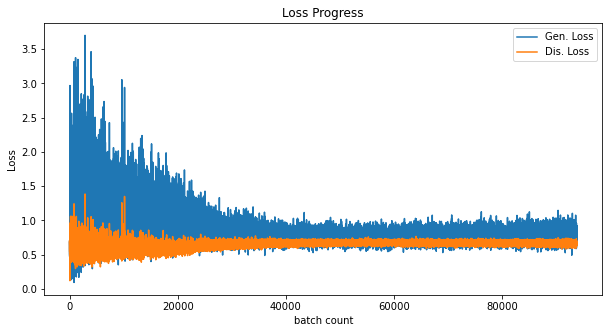

In [55]:
# plot loss history
plt.figure(figsize=(10,5))
plt.title('Loss Progress')
plt.plot(loss_history['gen'], label='Gen. Loss')
plt.plot(loss_history['dis'], label='Dis. Loss')
plt.xlabel('batch count')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 가중치 저장

In [57]:
path2models = './models/'
os.makedirs(path2models, exist_ok=True)
path2weights_gen = os.path.join(path2models, 'weights_gen.pt')
path2weights_dis = os.path.join(path2models, 'weights_dis.pt')

torch.save(model_gen.state_dict(), path2weights_gen)
torch.save(model_dis.state_dict(), path2weights_dis)

## Showing fake images made by Generator

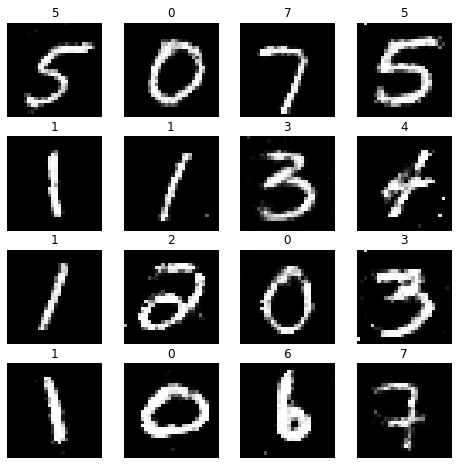

In [86]:
# 가중치 불러오기
weights = torch.load(path2weights_gen)
model_gen.load_state_dict(weights)

# evalutaion mode
model_gen.eval()

# fake image 생성
with torch.no_grad():
    fig = plt.figure(figsize=(8,8))
    cols, rows = 4, 4 # row와 col 갯수
    for i in range(rows * cols):
        fixed_noise = torch.randn(16, 100, device=device)
        label = torch.randint(0,10,(16,), device=device)
        img_fake = model_gen(fixed_noise, label).detach().cpu()
        fig.add_subplot(rows, cols, i+1)
        plt.title(label[i].item())
        plt.axis('off')
        plt.imshow(img_fake[i].squeeze(), cmap='gray')
plt.show()